# JPEG COMPRESSION ALGORITHM

### THÀNH VIÊN NHÓM
|MSSV|HỌ VÀ TÊN|
|---|---|
|19127003|NGUYỄN HỮU ĐẠT|
|19127472|NGUYỄN BÁ MINH|
|19127481|TRẦN HOÀNG NAM|
|19127595|NGUYỄN MINH TRÍ|


### GIỚI THIỆU ĐỒ ÁN
- File JPEG (hay File Joint Photographic Experts Group) là một loại định dạng hình ảnh được lưu bằng phương pháp lossy compression (nén có mất mát dữ liệu).Trong đó, hình ảnh đầu ra là kết quả của quá trình nén, là sự cân bằng giữa kích thước lưu trữ và chất lượng hình ảnh. Hơn [70% website](https://w3techs.com/technologies/details/im-jpeg) trên thế giới sử dụng ảnh có định dạng JPEG để lưu trữ
- Smartphone và camera sử dụng JPEG để lưu trữ
- Thuật toán nén video h.264 được sử dụng trên youtube sử dụng kỹ thuật nén tương tự JPEG
- Các thuật toán nén như JPEG giúp giảm thiểu chi phí lưu trữ, cũng như giảm thời gian khi gửi qua internet

Phía dưới là một pipeline của thuật toán nén JPEG Compression

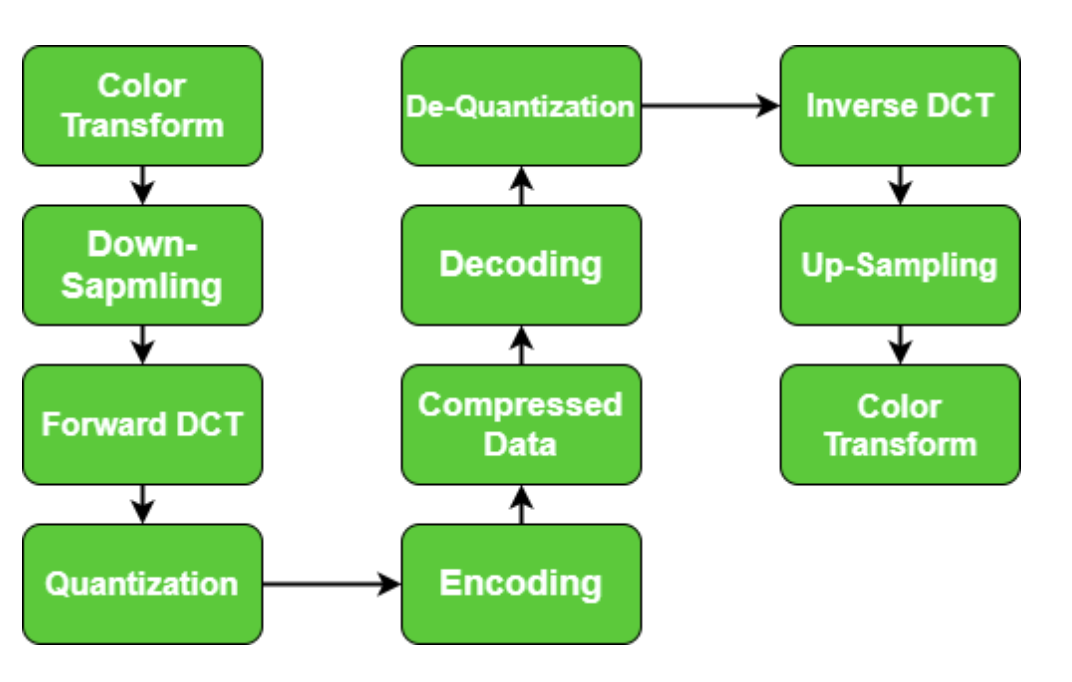

#### Mục tiêu của đồ án:
- Hiểu được cách hoạt động của thuật toán JPEG compression tuần tự: 50%
- Củng cố lại kiến thức về song song hoá trên GPU thông qua việc tối ưu hoá thuật toán bằng xử lý song song : 50%
  - Color transform: 10%
  - Down sampling: 10%
  - Forward DCT: 10%
  - Quantization: 10%
  - Encoding và compressed data: 10%

#### Các thách thức
- Học cách song song hoá bằng ngôn ngữ python
- Kiến thức mới về Discrete cosin transform (DCT),Quantization, mã hoá huffman
- Một vài bước trong thuật toán không thể song song hoàn toàn mà là song song một cách tuần tự

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import numba as nb
from numba import jit,prange,cuda
from PIL import Image
import cv2
import math

In [ ]:
devices = nb.cuda.list_devices()
for device in devices:
        print("Thiết bị GPU có ID:", device.id)

Thiết bị GPU có ID: 0


In [ ]:
selected_device = 0
nb.cuda.select_device(selected_device)

<weakproxy at 0x7ecf0d91c810 to Device at 0x7ecf0d911810>

# NỘI DUNG

##### LOAD ẢNH

#### CHUYỂN TỪ KÊNH MÀU RGB SANG KÊNH MÀU *YCbCr*

#### GIẢM KÍCH THƯỚC KÊNH MÀU CHROMINANCE

#### DISCRETE COSINE TRANSFORM

#### QUANTIZATION

## ZIGZAG SCANNING

## RUN LENGTH ENCODING

## HUFFMAN ENCODING

# THAM KHẢO